In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import os

In [50]:
n_x = 1000
x_array = np.linspace(0, 1, n_x)

R1o = 0.01
R2o = 1e5
Lo = 3.0
Co = 3.0
RL = 5.0

# Lo = 2.0
# Co = 2.0

dx = 0.001

R1 = R1o * dx
R2 = R2o / dx
L = Lo * dx
C = Co * dx

G = 1/R2

G = np.ones(x_array.shape) * G

# G[400] = G[400] * 1000000
# G[380:420] = G[380:420] * 1000000


def get_derivative(t, x):
    v = x[:n_x]
    i = x[n_x:]
    
    """
    if t <= 2  and t >= 1:
        u = 1
    else:
        u = 0
    """
    # u = np.sin(5/8 * t)
    # u = (1 - np.cos(3/2*t))+1
    u = (1 - np.cos(3/2 * t))/2

    v[0] = u
    i[-1] = v[-1]/RL
    
    der_v = np.zeros(v.shape)
    der_i = np.zeros(i.shape)
    
    der_v[1:] = 1/C* (i[:-1] - i[1:] - v[1:] * G[1:])
    der_i[:-1] = 1/L* (-v[1:] + v[:-1] - i[:-1] * R1)
    
    return np.concatenate((der_v, der_i))
    

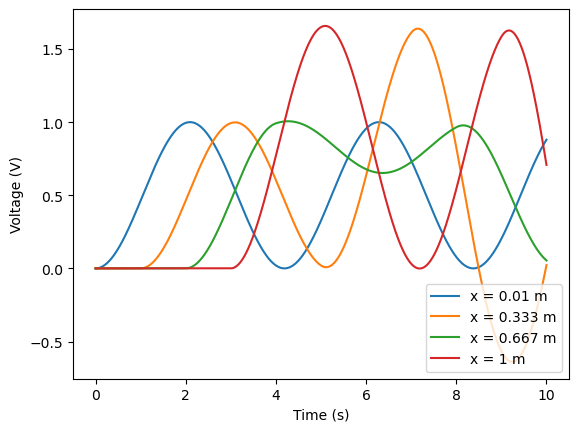

In [51]:
sol = solve_ivp(get_derivative, [0, 10], np.zeros(2*n_x), method='RK45', dense_output=True, rtol=1e-9, atol=1e-9)
plt.plot(sol.t, sol.y[0,:], label="x = 0.01 m")
plt.plot(sol.t, sol.y[int(n_x/3),:], label="x = 0.333 m")
plt.plot(sol.t, sol.y[int(2*n_x/3),:], label="x = 0.667 m")
plt.plot(sol.t, sol.y[n_x-1,:], label= "x = 1 m")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.legend(loc="lower right")
plt.show()

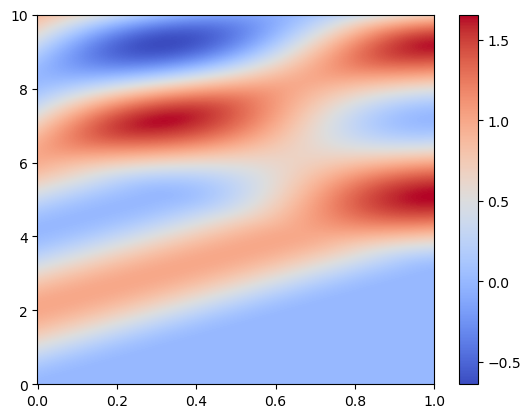

In [52]:
fig = plt.figure()
ax = fig.subplots()

T, X = np.meshgrid(sol.t, x_array)

colormesh = ax.pcolormesh(
    X,
    T,
    sol.y[:n_x, :],
    cmap="coolwarm"
)
fig.colorbar(colormesh)

In [10]:
v_sender_raw = sol.y[0, :]
v_receiver_raw = sol.y[n_x-1, :]
i_sender_raw = sol.y[n_x, :]
i_receiver_raw = sol.y[2*n_x-1, :]


t_data = np.linspace(0, 10, 200)
v_sender = np.interp(t_data, sol.t, v_sender_raw)
v_receiver = np.interp(t_data, sol.t, v_receiver_raw)
i_sender = np.interp(t_data, sol.t, i_sender_raw)
i_receiver = np.interp(t_data, sol.t, i_receiver_raw)

np.save(
    os.path.join("data", "case_a.npy"),
    {
        "t": t_data,
        "v_sender": v_sender,
        "v_receiver": v_receiver,
        "i_sender": i_sender,
        "i_receiver": i_receiver,
    }
)


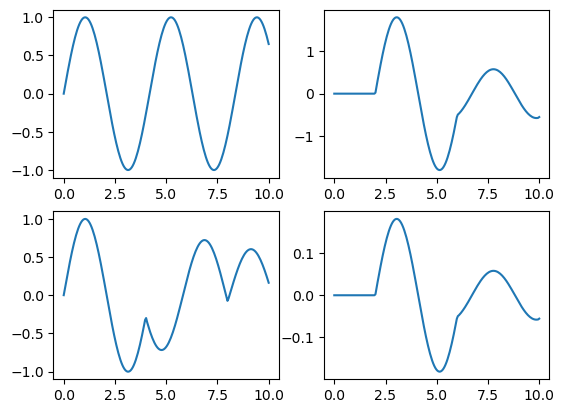

In [11]:
a = np.load("data/case_a.npy", allow_pickle=True).item()

# print(a["t"])

fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(a["t"], a["v_sender"])
axes[1, 0].plot(a["t"], a["i_sender"])

axes[0, 1].plot(a["t"], a["v_receiver"])
axes[1, 1].plot(a["t"], a["i_receiver"])

In [5]:
main_config = {
    "a": 0,
    "b": [],
    "c": "Sandia"
}

alt_configs = [
    {
        "cham": 30
    },
    {
        "priofsd": 15
    }
]

for conf in alt_configs:
    conf["main"] = main_config
    
print(main_config)
print(alt_configs)

    
for conf in alt_configs:
    conf["main"]["a"] += 1
    
print(main_config)
print(alt_configs)

{'a': 0, 'b': [], 'c': 'Sandia'}
[{'cham': 30, 'main': {'a': 0, 'b': [], 'c': 'Sandia'}}, {'priofsd': 15, 'main': {'a': 0, 'b': [], 'c': 'Sandia'}}]
{'a': 2, 'b': [], 'c': 'Sandia'}
[{'cham': 30, 'main': {'a': 2, 'b': [], 'c': 'Sandia'}}, {'priofsd': 15, 'main': {'a': 2, 'b': [], 'c': 'Sandia'}}]


(1000, 12746)
(998, 12744)
(998, 12744)
(998, 12744)
1.54708899932881


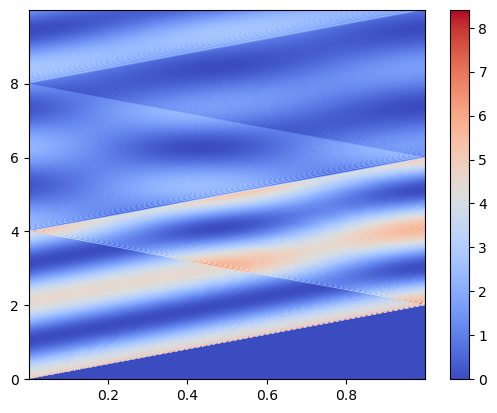

In [43]:
import torch

t_arr = sol.t
x_arr = x_array
U = sol.y[:n_x, :]
I = sol.y[n_x:, :]

dx = 10/len(x_arr)

print(U.shape)

u_x = (U[2:,:] - U[:-2, :])/np.repeat((x_arr[2:] - x_arr[:-2]).reshape(-1, 1), t_arr.shape[0], 1)
u_t = (U[:,2:] - U[:, :-2])/np.repeat((t_arr[2:] - t_arr[:-2]).reshape(1, -1), x_arr.shape[0], 0)

i_x = (I[2:,:] - I[:-2, :])/np.repeat((x_arr[2:] - x_arr[:-2]).reshape(-1, 1), t_arr.shape[0], 1)
i_t = (I[:,2:] - I[:, :-2])/np.repeat((t_arr[2:] - t_arr[:-2]).reshape(1, -1), x_arr.shape[0], 0)

u_x = u_x[:, 1:-1]
u_t = u_t[1:-1, :]
i_x = i_x[:, 1:-1]
i_t = i_t[1:-1, :]

u = U[1:-1, 1:-1]
i = I[1:-1, 1:-1]

print(u_x.shape)
print(u_t.shape)
print(u.shape)

R1o = 0.01
R2o = 1e5
Lo = 3.0
Co = 3.0
RL = 3.0

eq_1 = u_x + Lo * i_t + R1o * i
eq_2 = i_x + Co * u_t + 1/R2o * u

print(np.mean(eq_1**2 + eq_2**2))

fig = plt.figure()
ax = fig.subplots()

T, X = np.meshgrid(t_arr[1:-1], x_arr[1:-1])

colormesh = ax.pcolormesh(
    X,
    T,
    eq_1**2 + eq_2**2,
    cmap="coolwarm"
)
fig.colorbar(colormesh)
